<a href="https://colab.research.google.com/github/brittbowers/heartsounds_classification/blob/master/phonocardiogram_preprocess_2dcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Sound Machine Learning Challenge

This challenge is based on the [Physionet 2016 machine learning challenge](https://physionet.org/content/challenge-2016/1.0.0/). Numerous solutions to this challenge have been published and we encourage you to take advantage of previous work. We don't expect this exercise to take more than four hours. But there is a space at the end of the notebook to discuss other techniques you would try if you had more time. 

## Training Data

The training set for this challenge consists of the training data from the Physionet 2016 minus the data included in the test set. There is a file named REFERENCE.csv containing the audio file names and the corresponding labels. The meaning of the labels are as follows: 

```
Abnormal heart sound: 1
Normal heart sound: -1 
```

While training if you would like access to GPU or TPU hardware, you can select `Change runtime type` from the `Runtime` menu and select an accelerator type under `Hardware accelerator`. 

## Test Data

The test set data consists 301 recordings from the public validation set from the Physionet 2016 challenge. This is a balanced set of 150 normal and 151 abnormal recordings. We encourage you to not use this set for hyperparameter tuning and to save it to evaluate on at the end of the challenge.

## Evaluation

Tune your solutions to maximize the area under the ROC curve for detection of abnormal heart sounds. We will attempt to evaluate your model both on the test set provided and on a hidden holdout set. 

## Deliverable

Feel free to make any changes you like to the preprocessing or the classifier. Please share your updated colab notebook with the hiring manager. To help us understand your results, you can include explanations of the experiments you've performed and improvements that you've made using the colab notebook's text blocks. There is also a text block at the end of the notebook for you to summarize your changes. 

In [0]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.io import wavfile
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, ActivityRegularization, BatchNormalization
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [0]:
# Extra Imports
import librosa
from librosa import display
from tqdm import tqdm_notebook as tqdm
import pickle
import random
from keras.utils import to_categorical
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Background

The intro of this article (https://www.kdnuggets.com/2020/02/audio-file-processing-ecg-audio-python.html) does a good job of recapping cardiac physiology and framing the problem with regard to various heart sounds


# Download and preprocess data

In [0]:
! wget https://eko-public.s3.amazonaws.com/heart_sound_challenge.zip
! unzip -q heart_sound_challenge.zip

--2020-05-07 04:02:55--  https://eko-public.s3.amazonaws.com/heart_sound_challenge.zip
Resolving eko-public.s3.amazonaws.com (eko-public.s3.amazonaws.com)... 52.217.9.124
Connecting to eko-public.s3.amazonaws.com (eko-public.s3.amazonaws.com)|52.217.9.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163941805 (156M) [application/zip]
Saving to: ‘heart_sound_challenge.zip’

heart_sound_challen 100%[===================>] 156.35M  58.4MB/s    in 2.7s    

2020-05-07 04:02:58 (58.4 MB/s) - ‘heart_sound_challenge.zip’ saved [163941805/163941805]



## 1D Preprocessing (GIVEN)

In [0]:
TRAIN_PATH = 'heart_sound_challenge/train/'
TEST_PATH = 'heart_sound_challenge/test/'

def preprocess_data(PATH):
  # Load data reference
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))

  # Plug input data into numpy array
  x = np.zeros((len(labels), 2000*5, 1)) 
  for k, recording_id in enumerate(labels.recording_id):
    fs, audio = wavfile.read(os.path.join(PATH, recording_id + '.wav'))
    assert(fs == 2000)
    x[k, :, 0] = audio[:2000*5]/(2**15-1) 
    
  # Plug labels into numpy array
  y = pd.get_dummies(labels.label).values

  return x, y

X_train_1D, y_train_1D = preprocess_data(TRAIN_PATH)
X_test_1D,  y_test_1D  = preprocess_data(TEST_PATH)

## Visualizing the Data

I just want to get a better idea for what some of the raw files look like. 

Sampling Rate (fs) = number of samples (observations) in a second = 2000 above

In [0]:
TRAIN_PATH = 'heart_sound_challenge/train/'
TEST_PATH = 'heart_sound_challenge/test/'

def visualize_data(PATH):
  # Load data reference
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))

  for recording_id in labels.recording_id:
    data, sampling_rate = librosa.load(os.path.join(PATH, recording_id + '.wav'), sr=2000 )
    display.waveplot(data, sr=sampling_rate)
    break

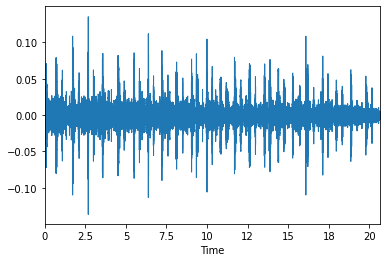

In [0]:
visualize_data(TRAIN_PATH)

## Segmentation

Dividing a particular object (here heart sound) into segements based on a defined set of characteristics. Here the goal is to align the inputs and make sure we are comparing the right sequences. I'll segment into S1, systole, S2, and diastole to align with the cardiac cycle. I may not have time to do this, but I believe it will improve performance

## 2D Preprocessing (Small Scale): Converting Audio Files to Spectrograms

I want to represent the audio file as a 2D image to run CNN as an image classifier. This will allow me to use transfer learning on well established image classification models. I saw this technique used in one of the papers (Rubin et al) from the contest and I like the ability to use CNN for it's "purpose"

In [0]:
def windows(data, window_size):
  # Function creates a shifting window which overlaps by 1/2 of each sequence
  start = 0
  while start < len(data):
    yield int(start), int(start + window_size)
    start += (window_size*0.5)

In [0]:
def display_ampspec(PATH):
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))
  for recording_id in tqdm(labels.recording_id):
    sound_clip, sr = librosa.load(os.path.join(PATH, recording_id + '.wav'), sr=44100)
    X = librosa.stft(sound_clip)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    break


  0%|          | 0/2939 [00:00<?, ?it/s]


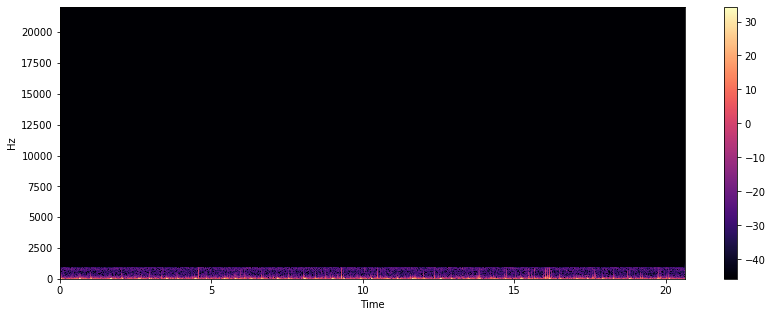

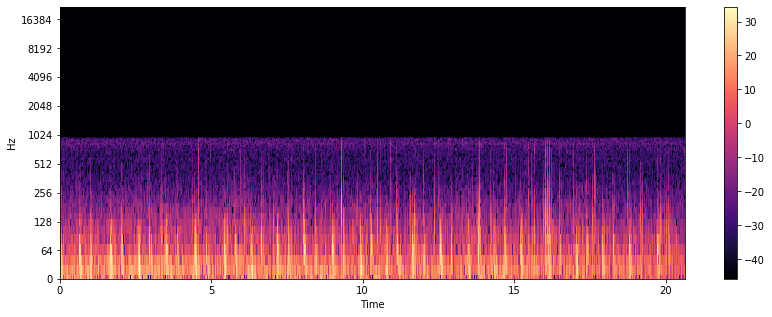

In [0]:
display_ampspec(TRAIN_PATH)

In [0]:
def display_melspec(PATH, bands=128):
  window_size = 512*127
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))
  for i,recording in enumerate(labels.label):
    if recording == 1:
      sound_clip, s = librosa.load(os.path.join(PATH, labels.loc[i,'recording_id'] + '.wav'))
      for (start, end) in windows(sound_clip, window_size):
        if len(sound_clip[start:end])==window_size:
          signal = sound_clip[start:end]
          melspec = librosa.feature.melspectrogram(signal, n_mels= bands)
          spec_shape = melspec.shape
          melSpec_dB = librosa.power_to_db(melspec, ref=np.max)
          plt.figure(figsize=(10, 5))
          librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=s, fmax=8000)
          plt.colorbar(format='%+1.0f dB')
          plt.title("MelSpectrogram Abnormal")
          plt.tight_layout()
          plt.show()
        break
    break
  for i,recording in enumerate(labels.label):
    if recording == 1:
      pass
    else:
      sound_clip, s = librosa.load(os.path.join(PATH, labels.loc[i,'recording_id']  + '.wav'))
      for (start, end) in windows(sound_clip, window_size):
        if len(sound_clip[start:end])==window_size:
          signal = sound_clip[start:end]
          melspec = librosa.feature.melspectrogram(signal, n_mels= bands)
          spec_shape = melspec.shape
          melSpec_dB = librosa.power_to_db(melspec, ref=np.max)
          plt.figure(figsize=(10, 5))
          librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=s, fmax=8000)
          plt.colorbar(format='%+1.0f dB')
          plt.title("MelSpectrogram Normal")
          plt.tight_layout()
          return plt.show()

### Visualizing an abnormal and normal Mel Spectrogram

You can see the abnormal image looks more blurry and has fewer defined peaks

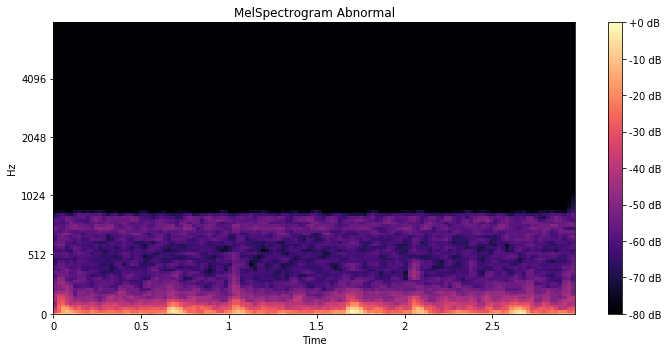

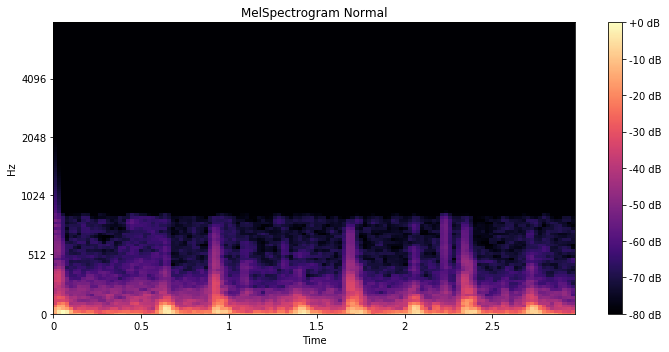

In [0]:
display_melspec(TRAIN_PATH)

### Get Melspec Array

For now I'm just going to take the first few seconds of every recording (1 window each). I don't think this is the best way, but it takes an eon to run this thing.

In [0]:
def get_features(PATH, bands=128, frames=128):
  # Hop length = 512
  window_size = 512*127
  X = []
  y = []
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))
  for i,recording_id in enumerate(tqdm(labels.recording_id)):
    sound_clip, s = librosa.load(os.path.join(PATH, recording_id + '.wav'))
    for (start, end) in windows(sound_clip, window_size):
        if len(sound_clip[start:end])==window_size:
          signal = sound_clip[start:end]
          melspec = librosa.feature.melspectrogram(signal, n_mels= bands)
          melSpec_dB = librosa.power_to_db(melspec, ref=np.max)
          X.append(melSpec_dB)
        break
  y = pd.get_dummies(labels.label).values
  return X,y 

In [0]:
X_train_2D, y_train_2D = get_features(TRAIN_PATH)

## 2D Preprocessing (Bulk Chunking)
I'm connecting this collab notebook to my personal google drive so that I can set up a preprocessing funnel to chunk the image data and not lose it. The pipeline will be as follows: <br/>
1) Read in sound clip using librosa <br/>
2) Cut data off at determined window size (~14 windows per sound clip if each window captures ~3 seconds) <br/>
3) Transform using FFT and Mel coeff <br/>
4) Write to csv <br/>
5) Start new csv at 2000 samples <br/>
- There should be ~10 chunked files using a cutoff of 2000


1st Run: Well I miffed this up. I accidentally captured the whole signal instead of the windows I'm going for and therefore wound up with arrays of all kinds of varying shapes. After quick research on whether I should scale or not (this preprocessing took forever so I wasn't particularly keen to run it again) I think I will end up running it again. Rip.

2nd Run: Fixed this shape/window problem



In [0]:
def chunk_preprocess(PATH, data_name, bands=128, frames=128):
  # Hop length = 512
  window_size = 512*127
  X = []
  y = []
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))
  count = 0
  cutoff = 0
  for i,recording_id in enumerate(tqdm(labels[158:].recording_id)):
    sound_clip, s = librosa.load(os.path.join(PATH, recording_id + '.wav'))
    for (start, end) in windows(sound_clip, window_size):
      if len(sound_clip[start:end])==window_size:
        count += 1
        cutoff += 1
        signal = sound_clip[start:end] 
        melspec = librosa.feature.melspectrogram(signal, n_mels= bands)
        melSpec_dB = librosa.power_to_db(melspec, ref=np.max)
        X.append(melSpec_dB)
        y.append(labels.loc[i,'label'])
      if cutoff >= 2000:
        print(i)
        with open(F"/content/gdrive/My Drive/heartsound_challenge/x_{data_name}_{count}.pickle", "wb") as fx:
          pickle.dump(X,fx)
          fx.close()
        with open(F"/content/gdrive/My Drive/heartsound_challenge/y_{data_name}_{count}.pickle", "wb") as fy:
          pickle.dump(y, fy)
          fy.close()
          cutoff = 0
          X = []
          y = []
  return print(count), print(cutoff)

In [0]:
chunk_preprocess(TEST_PATH, 'test')


1874
0


(None, None)

In [0]:
def chunk_png(PATH, bands=128, frames=128):
  # Hop length = 512
  window_size = 512*127
  count = 0
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))
  for i,recording_id in enumerate(tqdm(labels.recording_id)):
    sound_clip, s = librosa.load(os.path.join(PATH, recording_id + '.wav'))
    cutoff=0
    for (start, end) in windows(sound_clip, window_size):  
      if len(sound_clip[start:end])==window_size:
        label = labels.label[i]
        signal = sound_clip[start:end] 
        melspec = librosa.feature.melspectrogram(signal, n_mels= bands)
        melSpec_dB = librosa.power_to_db(melspec, ref=np.max)
        fig = plt.figure(figsize=(10, 5))
        p = librosa.display.specshow(melSpec_dB, sr=s, fmax=8000)
        fig.savefig(F'/content/gdrive/My Drive/heartsound_challenge/test/{count}_{label}.png')
        count += 1
        cutoff += 1
      if cutoff > 3:
        break

In [0]:
chunk_png(TEST_PATH)

# Train a 1D convolutional neural network model

For simplicity, we have defined this CNN in keras. But feel free to translate to the framework of your choice.

## Original (GIVEN)

In [0]:
# Get training and validation
X_train_1D, X_val_1D, y_train_1D, y_val_1D = train_test_split(X_train_1D, y_train_1D, test_size=0.2, random_state=42)

In [0]:
zeroes = 0
ones = 0
for num in y_train_1D:
  if num[0] == 0:
    zeroes += 1
  else:
    ones += 1
print(zeroes)
print(ones)

411
1940


In [0]:
batch_size = 128
num_classes = 2
epochs = 10

In [0]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(X_train_1D.shape[1], 1)))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))
  
model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 9996, 32)          192       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 9992, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1998, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1994, 64)          10304     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1990, 64)          20544     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 398, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 394, 128)         

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


## Experiment 1: Regularization <br/>

Activity regularization layer

In [0]:
batch_size = 128
num_classes = 2
epochs = 10

# import regularizer
from keras.regularizers import l2
# instantiate regularizer
reg = l2(0.001)

In [0]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))

model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))

model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))

model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))
                #Activation(tf.nn.softmax)))
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_233 (Conv1D)          (None, 9996, 32)          192       
_________________________________________________________________
conv1d_234 (Conv1D)          (None, 9992, 32)          5152      
_________________________________________________________________
max_pooling1d_169 (MaxPoolin (None, 1998, 32)          0         
_________________________________________________________________
activation_145 (Activation)  (None, 1998, 32)          0         
_________________________________________________________________
conv1d_235 (Conv1D)          (None, 1994, 64)          10304     
_________________________________________________________________
conv1d_236 (Conv1D)          (None, 1990, 64)          20544     
_________________________________________________________________
max_pooling1d_170 (MaxPoolin (None, 398, 64)         

## Experiment 2: Changing number of filters and filter length

In [0]:
batch_size = 128
num_classes = 2
epochs = 10

In [0]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(X_train_1D.shape[1], 1)))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))
  
model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 9996, 32)          192       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 9992, 32)          5152      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 1998, 32)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 1994, 64)          10304     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1990, 64)          20544     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 398, 64)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 394, 64)         

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


## Experiment 3: Adding dropout


In [0]:
from keras.optimizers import SGD

In [0]:
batch_size = 128
num_classes = 2
epochs = 20

In [0]:
model = Sequential()
model.add(Conv1D(32, 5, activation='selu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(32, 5, activation='selu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(64, 5, activation='selu'))
model.add(Conv1D(64, 5, activation='selu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.25))

model.add(Conv1D(128, 5, activation='selu'))
model.add(Conv1D(128, 5, activation='selu'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(128, 5, activation='selu'))
model.add(Conv1D(128, 5, activation='selu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_109 (Conv1D)          (None, 9996, 32)          192       
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 9992, 32)          5152      
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 1998, 32)          0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 1994, 64)          10304     
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 1990, 64)          20544     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 398, 64)           0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 398, 64)         

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


## Experiment 4: Removing convolutional Layers

In [0]:
model = Sequential()
model.add(Conv1D(32, 5, activation='elu', input_shape=(X_train_1D.shape[1], 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))

model.add(Conv1D(64, 5, activation='elu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv1D(128, 5, activation='elu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))

model.add(Conv1D(128, 5, activation='elu'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#model.add(Conv1D(128, 5,strides=6, activation='elu'))
#model.add(MaxPooling1D(pool_size=(5)))
#model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 9996, 32)          192       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 1999, 32)          0         
_________________________________________________________________
activation_26 (Activation)   (None, 1999, 32)          0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 1995, 64)          10304     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 399, 64)           0         
_________________________________________________________________
activation_27 (Activation)   (None, 399, 64)           0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 399, 64)         

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

## Train 1D Model

In [0]:
model.compile(
  loss=keras.losses.categorical_crossentropy,
  #optimizer=sgd,
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy'],
)

history = model.fit(
    X_train_1D, 
    y_train_1D,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    shuffle=True,
)

Epoch 1/10
1880/1880 [==============================] - 2s 1ms/step - loss: 0.4823 - acc: 0.8000
Epoch 2/10
1880/1880 [==============================] - 1s 286us/step - loss: 0.4257 - acc: 0.8261
Epoch 3/10
1880/1880 [==============================] - 1s 282us/step - loss: 0.3803 - acc: 0.8261
Epoch 4/10
1880/1880 [==============================] - 1s 282us/step - loss: 0.3361 - acc: 0.8261
Epoch 5/10
1880/1880 [==============================] - 1s 275us/step - loss: 0.3051 - acc: 0.8261
Epoch 6/10
1880/1880 [==============================] - 1s 278us/step - loss: 0.2932 - acc: 0.8463
Epoch 7/10
1880/1880 [==============================] - 1s 275us/step - loss: 0.2999 - acc: 0.8638
Epoch 8/10
1880/1880 [==============================] - 1s 280us/step - loss: 0.2983 - acc: 0.8638
Epoch 9/10
1880/1880 [==============================] - 1s 276us/step - loss: 0.2600 - acc: 0.8782
Epoch 10/10
1880/1880 [==============================] - 1s 277us/step - loss: 0.2449 - acc: 0.8952


# Training 2D CNN (Small Scale)

Running the CNN on just 1 image per sample (1 image being ~3 seconds of data

In [0]:
file_xtrain = open('heart_sound_challenge/train/X_train.pickle', 'rb')
X_train = pickle.load(file_xtrain)
file_ytrain = open('heart_sound_challenge/train/y_train.pickle', 'rb')
y_train = pickle.load(file_ytrain)

In [0]:
# Get training and validation
X_train_2D, X_val_2D, y_train_2D, y_val_2D = train_test_split(X_train_2D, y_train_2D, test_size=0.2, random_state=42)

In [0]:
X_train_2D = np.array(X_train_2D)
X_train_2D = np.expand_dims(X_train_2D, axis=3)

In [0]:
X_train_2D.shape

(2351, 128, 128, 1)

In [0]:
batch_size = 128
num_classes = 2
epochs = 20

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(128,128,1), data_format='channels_last'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
activation_9 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 128)      

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.adam(), 
              metrics=['accuracy'])
history = model.fit(
    X_train_2D, 
    y_train_2D,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    shuffle=True,
)

Epoch 1/20
2351/2351 [==============================] - 8s 3ms/step - loss: 2.5205 - acc: 0.7997
Epoch 2/20
2351/2351 [==============================] - 7s 3ms/step - loss: 1.4455 - acc: 0.8107
Epoch 3/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.4812 - acc: 0.8252
Epoch 4/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.4530 - acc: 0.8252
Epoch 5/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.4203 - acc: 0.8252
Epoch 6/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.4032 - acc: 0.8252
Epoch 7/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.3921 - acc: 0.8252
Epoch 8/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.3856 - acc: 0.8252
Epoch 9/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.3785 - acc: 0.8252
Epoch 10/20
2351/2351 [==============================] - 7s 3ms/step - loss: 0.3731 - acc: 0.8252
Epoch 11/20
2351/2351 [======

# Training 2D CNN (Bulk)

I'm running into issues still here that I need to sort out. I haven't run too many generators, so this is a debugging nightmare for sure. I still believe this model will improve performance once it works. 


In [0]:
train_files = []
test_files = []
with os.scandir('/content/gdrive/My Drive/heartsound_challenge/') as entries:
  for entry in entries:
    if 'train' in entry.name:
      train_files.append(entry.name)
    else:
      test_files.append(entry.name)

In [0]:
# Getting file names for validation set
train_files = np.array(train_files)
val_files = train_files[np.r_[0:2, 14:16, 32:34]]
train_files = train_files[np.r_[2:14,16:32, 34:]]

In [0]:
path = open(F"/content/gdrive/My Drive/heartsound_challenge/y_train_2000.pickle", 'rb')
y = pickle.load(path)

In [0]:
len(val_files)

6

In [0]:
def fileLoader(files, batch_size):
  L = len(files)
  while True:
    for file_x, file_y in zip(files[::2], files[1::2]):
      batch_start = 0
      batch_end = batch_size
      while batch_start < batch_end:
        path = open(F"/content/gdrive/My Drive/heartsound_challenge/{file_x}", 'rb')
        x = pickle.load(path)
        batch_x = x[batch_start:batch_end]
        batch_x = np.array(batch_x)
        batch_x = np.expand_dims(batch_x, axis=3)
        path = open(F"/content/gdrive/My Drive/heartsound_challenge/{file_y}", 'rb')
        y = pickle.load(path)
        batch_y = y[batch_start:batch_end]
        batch_y = np.array(batch_y)
        batch_y = np.expand_dims(batch_y, axis=1)
        batch_y = to_categorical(batch_y)
        yield (batch_x,batch_y) 
        batch_start += batch_size   
        batch_end += batch_size
      x = None
      y = None

In [0]:
batch_size = 200
num_classes = 2
epochs = 20

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(128,128,1), data_format='channels_last'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     


In [0]:
training_generator = fileLoader(train_files,200)
validation_generator = fileLoader(val_files,200)

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.adam(), 
              metrics=['accuracy'])
history = model.fit_generator(
    generator = training_generator, 
    validation_data = validation_generator, 
    use_multiprocessing=True,
    steps_per_epoch=210,
    validation_steps=30,
    epochs=20,
    verbose=1,
    shuffle=True,
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





 10/210 [>.............................] - ETA: 6:25 - loss: 0.7830 - acc: 0.9375

AxisError: ignored

# Evaluate the 1D model based on area under the ROC curve

**Using Validation and Test Set**

Baseline: 0.7683 <br/>
~~Kernal l2 regularize all layers: 0.559029~~ <br/>
~~Kernal l2 relarized every other: 0.723753~~ <br/>
~~Dropout every .25: 0.771~~ <br/>
Dropout every other .25: 0.787196 <br/>
~~Sigmoid activation: 0.4785~~ <br/>
Adding Activation Layer: 0.79660 <br/>
Removing 4 layers of convolution: 0.796247 <br/>
~~Making filters 64: 0.784150~~ <br/>
~~Making filters 128: 0.782428~~ <br/>
Added a convolutional layer: 0.804106 <br/>
~~Pool size 3 added a layer: 0.800177~~ <br/>
~~Pool size 3 added a layer: 0.804724~~ <br/>
~~Sigmoid activation on output: 0.780927~~ <br/>
~~3 conv layers, 6 strides, filter 64, elu: 0.752~~ <br/>
~~3 conv layers, 6 strides, filter 64, relu: 0.765386~~ <br/>
~~3 conv layers, 6 strides, filter 32 64 128, relu: 0.720706~~ <br/>
~~3 conv layers, 6 strides, filter 128, relu: 0.772627~~ <br/>
~~Batch normalization: 0.753731~~ <br/>
**HIGHEST SCORE: 0.0804724 (using full training set including validation)**




## Validation

In [0]:
X_val_1D.shape

(471, 10000, 1)

In [0]:
y_pred = model.predict(X_val_1D)

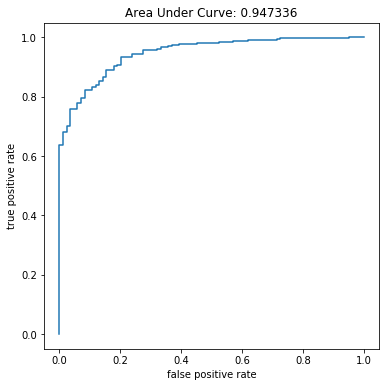

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val_1D[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_val_1D[:, 0], y_pred[:, 0])

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

## Test

In [0]:
y_pred = model.predict(X_test_1D)

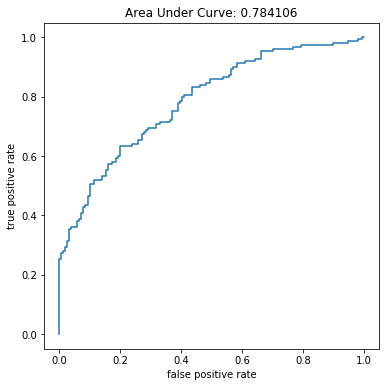

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_1D[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_test_1D[:, 0], y_pred[:, 0])

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

# Evaluate the 2D Model based on area under the ROC Curve (Small Scale)

Ok so right now the 2D network is performing worse than 1D. I think this is due to the fact that I'm only training on 1 window per sound clip. So the 1D network would actually have more data at this point. The preprocessing step takes a very long time and explodes quickly, so that's currently my bottleneck with this approach. 

In [0]:
X_val_2D = np.array(X_val_2D)
X_val_2D = np.expand_dims(X_val_2D, axis=3)
X_test_2D = np.array(X_test_2D)
X_test_2D = np.expand_dims(X_test_2D, axis=3)

## Validation

In [0]:
y_pred = model.predict(X_val_2D)

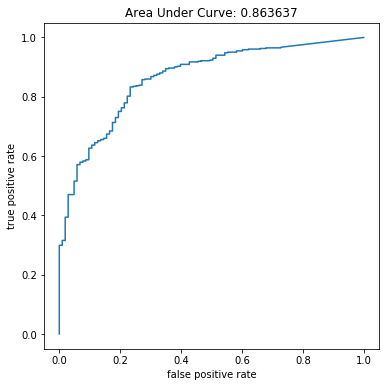

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val_2D[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_val_2D[:, 0], y_pred[:, 0])

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

## Test

In [0]:
y_pred = model.predict(X_test_2D)

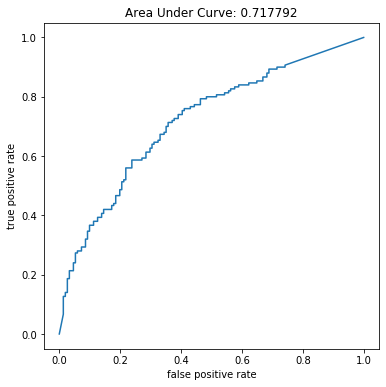

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_2D[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_test_2D[:, 0], y_pred[:, 0])

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

# Evaluate the 2D Model based on area under the ROC Curve (Bulk)

I haven't been able to get this model to train properly yet, but I think performance improvements are eminent on this one!

## Test

In [0]:
y_pred = model.predict(X_test_2D)

In [0]:
plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

# Research
This project borrows heavily from papers written in the 2016 PhysioNet Challenge. 

I read the following papers:
- Zabihi et al: https://physionet.org/content/challenge-2016/1.0.0/papers/zabihi.pdf
- Potes et al: https://physionet.org/content/challenge-2016/1.0.0/papers/potes.pdf
- Nilanon et al: https://physionet.org/content/challenge-2016/1.0.0/papers/nilanon.pdf
- Rubin et al: https://physionet.org/content/challenge-2016/1.0.0/papers/rubin.pdf

Also the following blogs:
- Shaikh for sound segmentation: https://www.analyticsvidhya.com/blog/2017/11/heart-sound-segmentation-deep-learning/
- Jain on regularization for deep learning: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/
- Roy for audio file processing https://www.kdnuggets.com/2020/02/audio-file-processing-ecg-audio-python.html
- Srinivasan for more audio processing https://www.kdnuggets.com/2020/02/audio-file-processing-ecg-audio-python.html
- Gartzman on Mel Spectrograms https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
- AI graduate on CNN and mel https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e

Also this site for cryptography:
http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

And advice from a few friends:
- Naryan Murthy (signal processing)
- Richard Chiou (CNN)

Rubin et al wrote a more detailed paper (http://ceur-ws.org/Vol-1891/paper2.pdf) which was the source of much ideation involving segmentation and transformation

Something to read for more detail in the future:
https://timsainburg.com/python-mel-compression-inversion.html

# Discussion
**Please discuss the algorithm performance and explain the changes you made which led to performance gains.**

**Using the 1D CNN** <br/>

I will say that not all iterations are captured in the experimentaion section due to space consideration. I tried to keep a few iterations of large pattern changes. 

Things I Tried: 
- Regularization
- Adding convolutional layers
- Adding activation layers
- Changing activation type from relu to elu and sigmoid
- Changing the filter size
- Increasing dropout size and/or dropout layers
- Changing the pool sizing
- Changing the number of max pool layers
- Batch Normalization
- Introduced strides
- Increasing number of epochs

Summary of Positive Changes: <br/>
- Changed activation type in convolutional layer to 'elu' and added extra activation layers
- Removed extra convolutional layers
- Added dropout layers of 0.25 throughout
- Batch normalization

**Using 2D CNN**

I didn't have time to investigate many networks for this approach, because preprocessing and pipelining was a bit of a challenge, but I'd investigate this in the future.

Summary of Model: <br/>
Using learnings from the 1D model building I just went with a basic architecture. The first iteration seemed to perform ok, but not better than the 1D due to data limitations. 

**Please discuss other things you would try if you had additional time that might further improve performance.**

1) I would try segmentation of heartsounds clips using S1 and S2 classification

2) There are some tuning things I would do to the 2D model 

3) I'd love to use transfer learning to apply an image classifier on the melspecs. 